In [130]:
%matplotlib notebook

import numpy as np
import cv2
import scipy.cluster.hierarchy
from glob import glob
from PIL import Image
from ipywidgets import interact, fixed, IntSlider
from matplotlib import pyplot as plt
from itertools import islice
from scipy.ndimage import measurements, morphology

In [131]:
def show_images(images):
    fig = plt.figure()
    for i in range(len(images)):
        img = images[i]
        a = fig.add_subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=(None if len(img.shape) == 3 else 'gray'))
        #plt.axis('off')
    plt.show()

def show_rgb(img):
    show_images([img])
    
def show_hsv(images):
    show_images(cv2.cvtColor(img, cv2.COLOR_HSV2RGB) for img in images)

def show_gray(images):
    show_images(images)

<IPython.core.display.Javascript object>


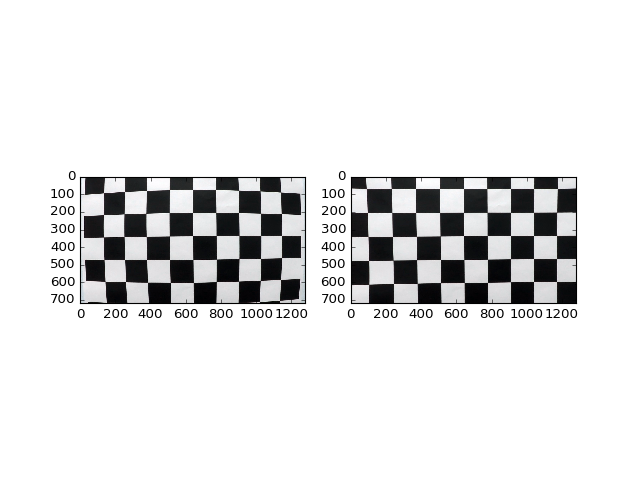

In [132]:
chess_shape = (9, 6)
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for path in glob('camera_cal/*'):
    img = cv2.imread(path) 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chess_shape, None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

for path in islice(glob('camera_cal/*'), 1):
    img = cv2.imread(path)
    dst = undistort(img)
    show_images([img, dst])

<IPython.core.display.Javascript object>


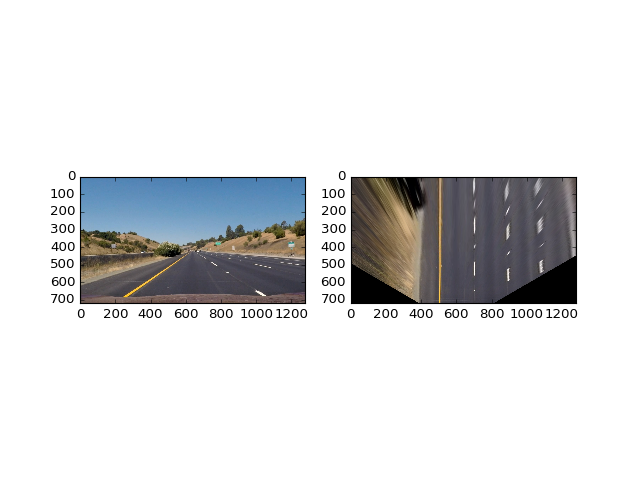

<IPython.core.display.Javascript object>


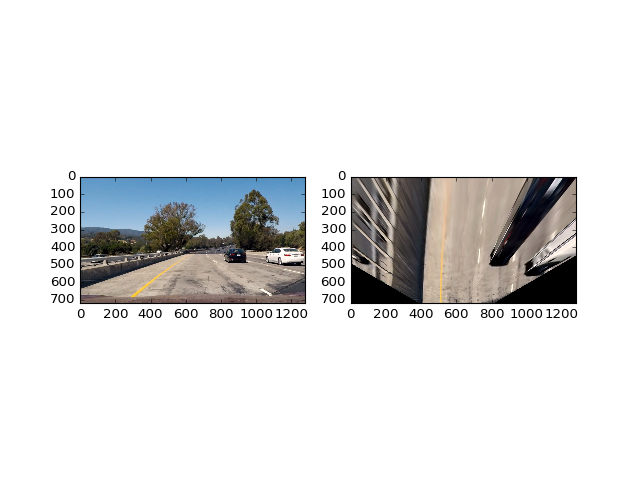

In [133]:
src = np.float32([
        [253, 685],
        [572, 465],
        [709, 465],
        [1052, 685]])

dst = np.float32([
        [500, 750],
        [500, 300],
        [700, 300],
        [700, 750]])

M = cv2.getPerspectiveTransform(src, dst)

def get_road(img):
    img_size = (img.shape[1], img.shape[0])
    # we mostly are interested in upscaling and CUBIC seems to be quite good
    # http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_CUBIC)
    
for i in islice(glob('test_images3/*'), 2):
    img = np.asarray(Image.open(i))
    road = get_road(img)
    show_images([img, road])


residuals: [  2.26069007e+00  -4.44956430e+01   3.78075829e+02  -1.80994419e+03
   5.33186850e+03  -9.85782003e+03   1.10009853e+04  -6.24936852e+03
   2.22814828e+02   1.62414435e+03  -5.93541431e+02]
rank: [ 1.12591489]
singular_values: 11
rcond: [  3.13318194e+00   1.04627068e+00   2.90572103e-01   6.31336236e-02
   8.30276027e-03   1.27183813e-03   1.23129042e-04   9.32131012e-06
   7.87228707e-07   2.55855523e-08   9.56176776e-10]
pre: 1.11022302463e-14
       10        9         8        7        6        5           4
2.261 y  - 44.5 y + 378.1 y - 1810 y + 5332 y - 9858 y + 1.1e+04 y
         3         2
 - 6249 y + 222.8 y + 1624 y - 593.5


<IPython.core.display.Javascript object>


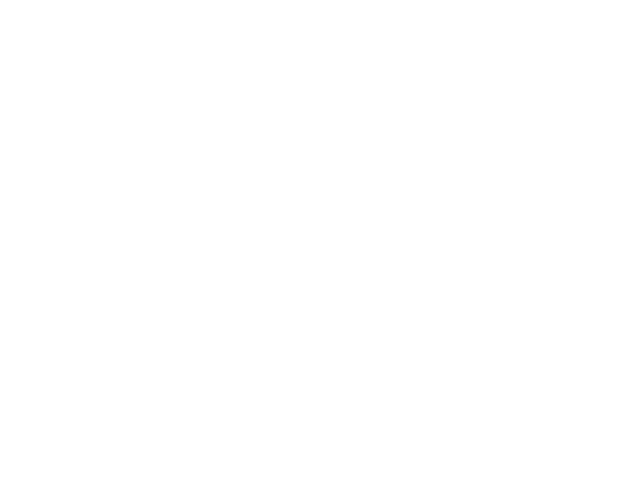

In [54]:
#points = np.random.random((10, 2))
pp = []
for p in [[5, 1], [4, 3], [4.5, 2.5], [4.7, 2.3], [3.9, 2]]:
    for i in range(10):
        pp.append([p[0]+np.random.random()*0.4, p[1]+np.random.random()*0.4])
        
points = np.array(pp)

x = points[:, 0]
y = points[:, 1]

residuals, rank, singular_values, rcond, pre = np.polyfit(y, x, 10, full=True)
print("residuals: %s" % residuals)
print("rank: %s" % rank)
print("singular_values: %s" % singular_values)
print("rcond: %s" % rcond)
print("pre: %s" % pre)

f = np.poly1d(residuals, variable='y')
print(f)

y_new = np.linspace(min(y), max(y), 50)
x_new = f(y_new)

plt.figure()
plt.margins(0.1, 0.1)
plt.plot(x, y, '.', x_new, y_new)
plt.show()

<IPython.core.display.Javascript object>


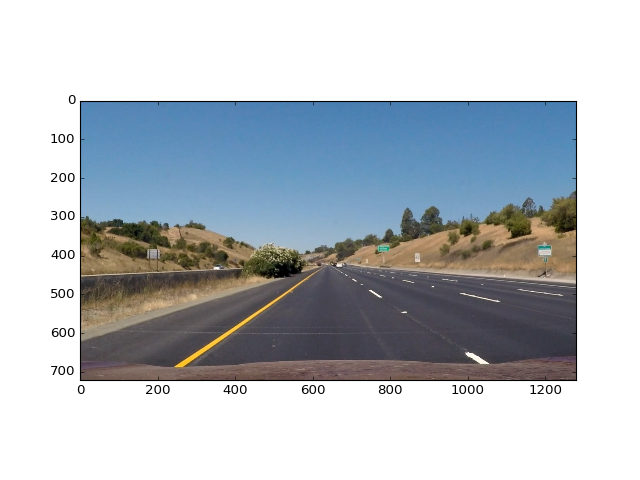

<IPython.core.display.Javascript object>


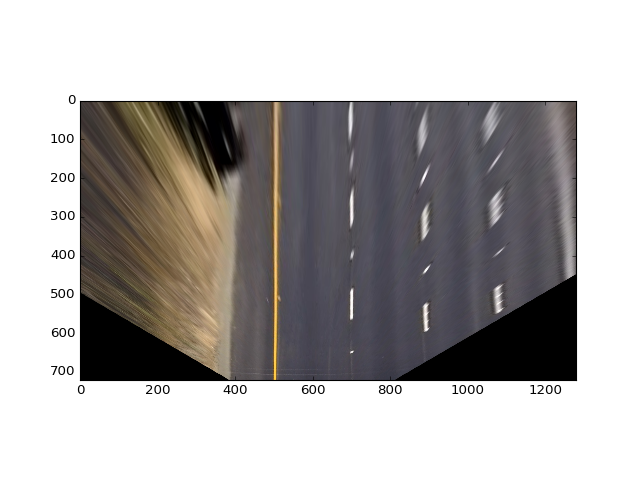

yellow:


<IPython.core.display.Javascript object>


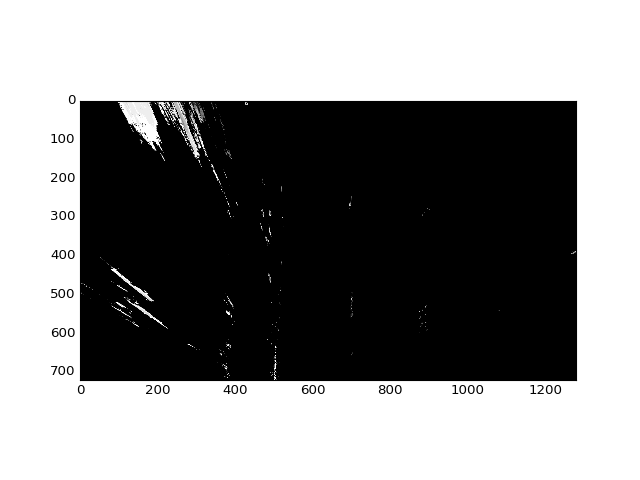

<IPython.core.display.Javascript object>


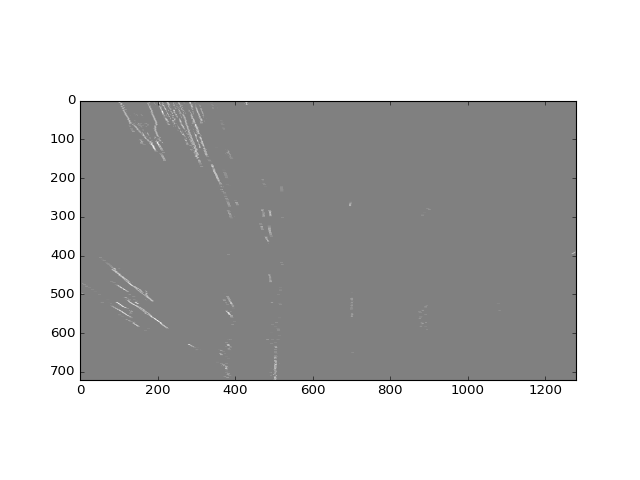

<IPython.core.display.Javascript object>


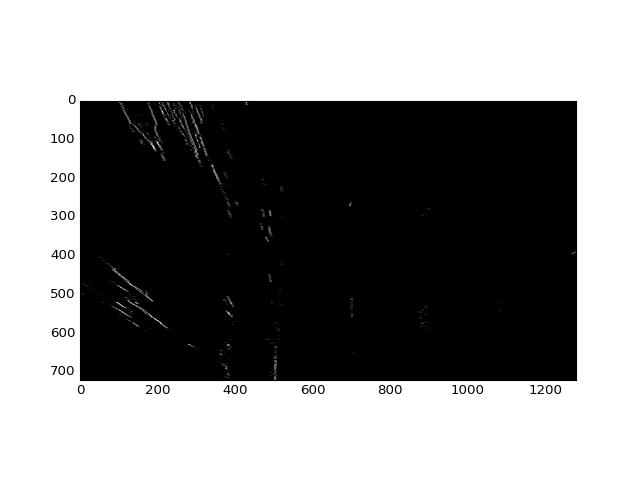

Number of objects: 527


<IPython.core.display.Javascript object>


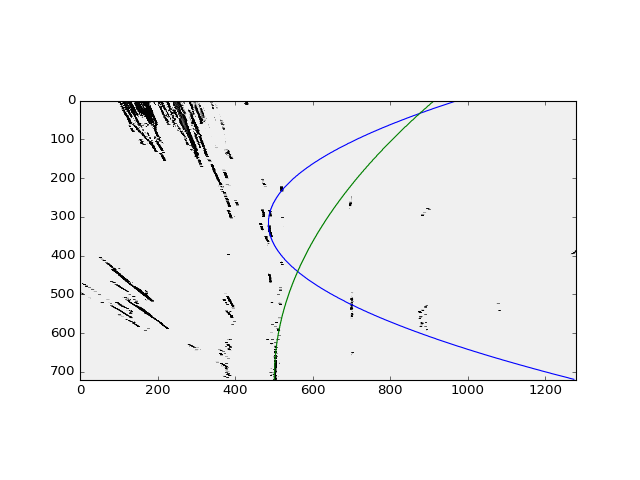

[  4.86122902e-03  -3.07490884e+00   9.72417340e+02]
[  8.12275230e-04  -1.15692895e+00   9.13847537e+02]


In [251]:
def find_lane_yellow_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,v]
    mask = np.zeros_like(h)
    mask[(h > 15) & (h <= 31)] = 1
    return mask
    
def find_lane_gray_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.zeros_like(gray)
    mask[gray >= 225] = 1
    return mask

def norm(v):
    return np.sqrt(v.dot(v))

class Line():
    def __init__(self, label, pixels):
        self.label = label
        self.pixels = pixels
        residuals, rank, singular_values, rcond, pre = np.polyfit(self.pixels[0], self.pixels[1], 2, full=True)
        self.poly = np.poly1d(residuals, variable='y')
        
        
def find_bright_lanes(img):
    g_min = np.min(img)
    g_max = np.max(img)
    
    gray = (img - g_min) / (g_max - g_min)
    
    show_images([gray])

    line_width = 8
    kernel = np.concatenate((np.repeat(-1, line_width / 2), 
                             np.repeat( 1, line_width), 
                             np.repeat(-1, line_width / 2)))

    kernel = kernel / np.sum(np.abs(kernel))
    kernel = kernel.reshape(1, -1)
    
    conv = cv2.filter2D(gray, -1, kernel)
    show_images([conv])
    c_max = np.max(conv)
    conv[conv < 0.05] = 0
    show_images([conv])
    
    
    def extract_lines(labels, object_count):
        print("Number of objects: {}".format(object_count))
        
        lines = []

        for label in range(1, object_count + 1):
            pixels = np.where(labels == label)
            if len(pixels[0]) > 200:
                for p in zip(*pixels):
                    if p[0] > 300 and p[1] > 400 and p[1] < 800:
                        lines.append(Line(label, pixels))
                        break
            
        return lines
    

    def show_with_lines(gray, lines):
        fig, ax = plt.subplots()

        for line in lines:
            try:
                f = line.poly

                ys = np.array(range(0, gray.shape[0]))
                xs = np.int64(f(ys))
                ax.plot(xs, ys)
            except:
                print("Failed:")
                print(line.pixels)
    
        marked = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        marked[np.nonzero(labels)] = [255, 255, 255]
        ax.imshow(marked)
        plt.show()
    
    
    labels, object_count = measurements.label(conv)    

    lines = extract_lines(labels, object_count)
    show_with_lines(gray, lines)
    
    coeffs = [l.poly.coeffs for l in lines]
    
    for c in coeffs:
        print(c)
        
    return
        
    central = np.average(coeffs, axis=0)
    
    lefts = []
    rights = []
    
    for l in lines:
        if l.poly(img.shape[0]) < 600:
            lefts.append(l)
        else:
            rights.append(l)
           
    lefts.sort(key=lambda l: abs(l.poly.coeffs[0]))
    rights.sort(key=lambda l: abs(l.poly.coeffs[0]))
    
    left_line = Line(1, lefts[0].pixels)
    right_line = Line(2, rights[0].pixels)

    show_with_lines(img, [left_line, right_line])
    
    lane_direction = np.poly1d(np.average([l.poly.coeffs for l in [left_line, right_line]], axis=0))
    
    car_offset = lane_direction(lane_direction(img.shape[0])) - 600
    curvature = (((1 + (2*lane_direction.coeffs[0]*img.shape[0] + lane_direction.coeffs[1])**2)**1.5) 
                 / np.absolute(2*lane_direction.coeffs[0]))
    
    print("car_offset: {}, curvature: {}".format(car_offset, curvature))
    
    
    #lines2 = extract_lines(labels, object_count)
    
    

def find_lanes(img):
    show_images([img])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]
    yellow = np.copy(h)
    yo = 2
    yc = 22
    yellow = (yo - np.minimum(np.abs(yellow - yc), yo) * np.float32(255 / yo))
    #yellow = cv2.inRange(h, 18, 30)
    #yellow[(h < 18) | (h > 30)] = 0
    #lane_colors = np.maximum(gray, yellow)
    lane_colors = yellow
    find_bright_lanes(lane_colors)

    
for i in islice(glob('test_images3/*'), 1):
    img = np.array(Image.open(i))
    show_images([img])
    find_lanes(get_road(img))


<IPython.core.display.Javascript object>


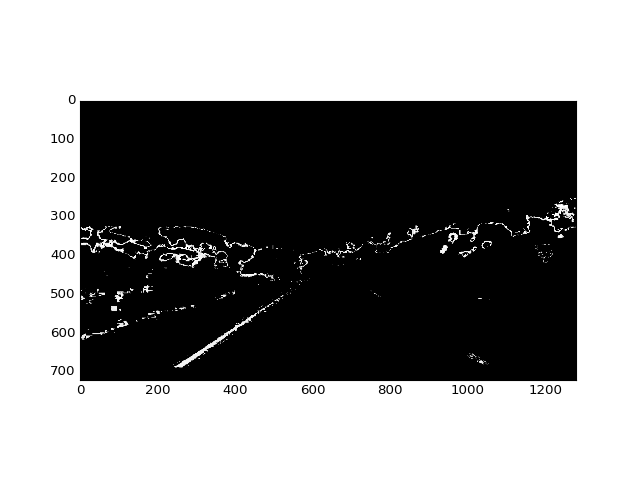

In [247]:
img = np.array(Image.open('test_images3/straight_lines1.jpg'))
    
@interact(img = fixed(img), lh = IntSlider(min=0, max=255, value=15), hh = IntSlider(min=0, max=255, value=31))
def show_hue(img, lh, hh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    h[(h < lh) | (h > hh)] = 0
    #show_images([img])
    plt.figure()
    plt.imshow(h, cmap = 'gray')
    plt.show()
    


In [ ]:
for i in islice(glob('test_images2/*'), 8):
    img = np.array(Image.open(i))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.blur(gray, ksize=(3, 3))
    contours = cv2.findContours(gray, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    print(contours)
    for j in range(len(contours)):
        cv2.drawContours(img, np.array(contours), j, [255, 0, 0])

In [ ]:
@interact(x=(0, 20))
def update_image(x):
    img = np.asarray(Image.open(i))
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(img, mask, (345, 647), (255, 0, 0), (x, x, x), (x, x, x))
    plt.imshow(img)